 # Raman COVID saliva dataset LOOCV

## import the packages

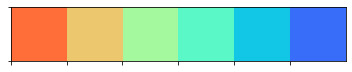

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from aggmap import AggMap
from joblib import load,dump

from utils.dscarnet import dual_dscarnet
from utils.PCA_tool import PCA_transform
np.random.seed(888)

color = sns.color_palette("rainbow_r", 6) 
sns.palplot(color)


os.environ["CUDA_VISIBLE_DEVICES"]="0"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)


## data processing

In [2]:
df = pd.read_csv('dataset/covid.csv').iloc[:,1:]

In [3]:
df

,401.232,402.588,403.942,405.297,406.651,408.004,409.359,410.712,412.064,413.417,...,1590.88,1591.96,1593.04,1594.1199999999997,1595.2,1596.28,1597.36,1598.44,1599.52,label
0,0.463132,0.488629,0.548814,0.549793,0.535041,0.557509,0.548889,0.506501,0.434364,0.407594,...,0.400069,0.364285,0.363653,0.370401,0.364635,0.369394,0.424976,0.414288,0.403600,COV-_26
1,0.519605,0.538010,0.556414,0.511574,0.505251,0.498928,0.456681,0.490032,0.501757,0.469651,...,0.475490,0.461815,0.479985,0.498155,0.493566,0.474229,0.479446,0.499177,0.518908,COV-_26
2,0.497023,0.498506,0.486636,0.515396,0.508132,0.458349,0.461755,0.457779,0.395725,0.372012,...,0.448286,0.452395,0.437673,0.462277,0.471007,0.460923,0.445979,0.449418,0.452856,COV-_26
3,0.477051,0.500407,0.488590,0.470271,0.438019,0.424541,0.435799,0.422239,0.443750,0.395329,...,0.409197,0.398732,0.391691,0.390964,0.409555,0.412434,0.426624,0.422111,0.417598,COV-_26
4,0.504614,0.503676,0.481012,0.495373,0.488682,0.461627,0.475700,0.485671,0.482026,0.450307,...,0.489558,0.450081,0.478326,0.496475,0.491546,0.477951,0.481056,0.470655,0.460255,COV-_26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.448708,0.516972,0.509951,0.487877,0.465803,0.466374,0.468799,0.465497,0.470083,0.449603,...,0.383358,0.358878,0.355310,0.352450,0.331982,0.345020,0.372235,0.349210,0.326185,CTRL_23
2497,0.448979,0.474620,0.483923,0.493136,0.477703,0.449586,0.463451,0.502552,0.474716,0.452484,...,0.341181,0.342899,0.340492,0.327070,0.344951,0.325316,0.327454,0.334920,0.342385,CTRL_23
2498,0.438763,0.500359,0.527969,0.556297,0.546658,0.509813,0.504508,0.485561,0.446410,0.395002,...,0.309652,0.311105,0.326765,0.354025,0.373314,0.370471,0.363528,0.357542,0.351556,CTRL_23
2499,0.470068,0.533605,0.534146,0.489090,0.459930,0.466751,0.471294,0.449973,0.437918,0.418259,...,0.365946,0.354501,0.349874,0.345248,0.328328,0.341598,0.372647,0.377755,0.382863,CTRL_23


In [4]:
df_pca = PCA_transform(df.iloc[:,:-1],40)

In [5]:
df_pca

,0,1,2,3,4,5,6,7,8,9,...,1476,1477,1478,1479,1517,1518,1519,1558,1559,1599
0,0.172017,0.104066,0.135574,0.154391,0.162701,-0.029685,0.311099,0.331354,0.161324,0.034477,...,-0.933081,-1.181541,-0.937227,-1.017673,-0.737311,-0.797298,-0.876710,-0.389243,-0.627835,-0.499726
1,1.838748,1.185608,2.096433,2.042237,1.884996,1.585311,2.162959,2.002749,1.913847,1.620411,...,-0.419642,0.276107,-0.939203,0.440752,0.813692,-0.065622,1.326530,-0.911451,0.095833,1.065531
2,1.280362,0.792654,1.485858,1.527640,1.214140,1.026513,1.566167,1.419417,1.257110,1.132638,...,-0.149625,1.883513,0.111370,-0.493091,2.821937,2.219551,1.632859,0.309780,-0.166893,-0.553916
3,1.146721,1.127938,1.324397,1.341820,1.199865,1.057283,1.523887,1.362573,1.207003,0.954386,...,0.079868,0.702033,-0.735846,-2.650064,0.915383,-0.145836,-2.060304,-1.127495,-3.528142,-3.888169
4,1.684977,1.071939,1.843993,1.936646,1.693799,1.428853,1.958424,1.767045,1.696420,1.590037,...,-2.068986,-1.712761,-0.921910,0.126187,-0.348249,0.304154,1.366731,0.781634,2.178586,2.313861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,-1.225285,-1.345761,-1.120711,-1.140978,-1.146940,-1.173468,-1.167319,-1.213335,-1.120777,-1.186799,...,0.055781,0.060999,0.175683,0.645374,0.030411,0.157976,0.628908,0.193470,0.747008,0.869345
2497,-1.369753,-1.254317,-1.344334,-1.297557,-1.256610,-1.322292,-1.324201,-1.369758,-1.288801,-1.354208,...,-0.079445,-0.802710,-0.344918,0.357596,-1.058600,-1.039953,-0.341805,-0.410259,0.124270,0.595445
2498,-0.652632,-0.737242,-0.840373,-0.729828,-0.581365,-0.616018,-0.533358,-0.627326,-0.553369,-0.635052,...,-0.780476,-0.596668,-1.343564,0.037290,-0.061259,-0.834258,0.555403,-1.121610,-0.199494,0.858041
2499,-0.187577,-0.132739,-0.626367,-0.359026,-0.172416,-0.282732,0.006586,-0.154013,-0.116912,-0.214651,...,0.514810,0.252516,-1.352171,0.135034,-0.159651,-1.836534,-0.349429,-2.444173,-1.980282,-0.336722


In [6]:
# channel 11 for another example
mp_sar = AggMap(df.iloc[:,:-1],metric = 'euclidean')
mp_sar = mp_sar.fit(cluster_channels = 11, verbose = 0)
mp_sar.save('mp_example/covid_sar.mp')

2024-06-02 23:52:03,162 - INFO - [bidd-aggmap] - Calculating distance ...
2024-06-02 23:52:03,427 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 991/991 [00:01<00:00, 504.87it/s]


2024-06-02 23:52:27,771 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-06-02 23:52:36,809 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-06-02 23:52:38,203 - INFO - [bidd-aggmap] - Finished


['mp_example/covid_sar.mp']

In [7]:
# channel 11 for another example
mp_car = AggMap(df_pca,metric = 'euclidean')
mp_car = mp_car.fit(cluster_channels = 11, verbose = 0)
mp_car.save('mp_example/covid_car.mp')

2024-06-02 23:52:38,277 - INFO - [bidd-aggmap] - Calculating distance ...
2024-06-02 23:52:38,328 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 820/820 [00:01<00:00, 498.94it/s]


2024-06-02 23:52:55,241 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-06-02 23:52:58,219 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-06-02 23:52:58,836 - INFO - [bidd-aggmap] - Finished


['mp_example/covid_car.mp']

In [8]:
mp_sar = load('mp_example/covid_sar.mp')
mp_car = load('mp_example/covid_car.mp')

## model training

In [9]:
def _vote_for_one_sample(array):
    elements, counts = np.unique(array, return_counts=True)
    max_count_index = np.argmax(counts)
    return elements[max_count_index]

def vote(array, sample_counts):
    patient_labels = []
    start_index = 0

    for patient_index, count in sample_counts.items():
        patient_samples = array[start_index:start_index + count]
        most_frequent_label = _vote_for_one_sample(patient_samples)
        patient_labels.append(most_frequent_label)
        start_index += count

    return patient_labels


In [10]:
from utils.dscarnet import dual_dscarnet


In [11]:
from sklearn.model_selection import train_test_split

count = 0
labels = df['label']

# Transform labels based on prefix
def transform_labels(label_series):
    return label_series.apply(lambda x: 2 if 'COV+' in x else (1 if 'COV-' in x else 0))

# Prepare outer loop (leave-one-out)
patients = labels.unique()
np.random.shuffle(patients)

for test_patient in patients:
    
    print(f'{test_patient}, No: {count+1}')
    count += 1
    
    test_set = df[df['label'] == test_patient]
    train_set = df[df['label'] != test_patient]
    
    test_set_pca = df_pca[df['label'] == test_patient]
    train_set_pca = df_pca[df['label'] != test_patient]

    X_ts = mp_sar.batch_transform(test_set.iloc[:, :-1].values, scale_method='minmax')
    X_ts_pca = mp_car.batch_transform(test_set_pca.values, scale_method='minmax')
    Y_ts = np.unique(transform_labels(test_set['label']))

    X_tr = mp_sar.batch_transform(train_set.iloc[:, :-1].values, scale_method='minmax')
    X_tr_pca = mp_car.batch_transform(train_set_pca.values, scale_method='minmax')
    Y_tr = pd.get_dummies(transform_labels(train_set['label'])).values

    
    print('Start training!')

    train_idx, valid_idx = train_test_split(np.arange(len(X_tr)), test_size=0.1, stratify=transform_labels(train_set['label']))
    trainX, validX = (X_tr[train_idx], X_tr_pca[train_idx]), (X_tr[valid_idx], X_tr_pca[valid_idx])
    trainY, validY = Y_tr[train_idx], Y_tr[valid_idx]

    model_tr = dual_dscarnet(X_tr.shape[1:], X_tr_pca.shape[1:], n_outputs=Y_tr.shape[-1], 
                             conv1_kernel_size=19, n_inception=1, dense_layers=[128], 
                             dense_avf='relu', batchnorm=False, last_avf='softmax')

    opt = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model_tr.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=50, 
                                                      restore_best_weights=True)

    history = model_tr.fit(trainX, trainY,
                           batch_size=128, 
                           epochs=800, verbose=0, shuffle=True, 
                           validation_data=(validX, validY), 
                           callbacks=[ early_stopping_cb])


    predictions = np.argmax(model_tr.predict((X_ts, X_ts_pca)), 1)
    sample_counts = {test_patient: len(X_ts)}
    voted_prediction = vote(predictions, sample_counts)

    accuracy = 1 if voted_prediction == Y_ts else 0
    print(f'{test_patient} accuracy: {accuracy}')
    break #1 patient for example


COV+_10, No: 1


100%|##########| 2476/2476 [00:05<00:00, 423.77it/s]


Start training!
COV+_10 accuracy: 1
